# Functionalized Backtester 

In [3]:
import pandas as pd 
import numpy as np
from backtest.positions import ransac_beta
from pairs import selection 

from copulas.copulae import GumbelCopula 
from backtest.signal_ import SignalGeneration
from analysis.performance import perf_summ 

from sklearn.linear_model import RANSACRegressor, HuberRegressor
from backtest.signal_ import SignalGeneration
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Importing Price Data

In [4]:
filename = 'tickers.csv'
ticker_names = pd.read_csv(filename,index_col=0)

ticker_names = ticker_names[~ticker_names['Type'].str.contains('Fixed Income',regex=False)]
ticker_list = ticker_names['Ticker']
ticker_list = ticker_list.drop_duplicates()

filename = 'raw_data.csv'
rawdata = pd.read_csv(filename)
raw_prices = rawdata.pivot_table(index='date',values='close',columns='ticker')
raw_prices = raw_prices.loc[:, raw_prices.columns.isin(ticker_list)]

WINDOW_SIZE = 252 
MOD_REGRESSION = 3 
TRANSACTION_COST = 0.000

In [5]:
def beta_calc(asset_1,asset_2,mkt,mod=MOD_REGRESSION):
    # Calculate each asset's beta to the market.
    # Use RANSAC to remove outliers.
    
    if mod in [1,4,5]:
        a1 = (np.log(asset_1) - np.log(asset_1.shift(1))).cumsum().dropna()
        a2 = (np.log(asset_2) - np.log(asset_2.shift(1))).cumsum().dropna()
        mkt_data = (np.log(mkt) - np.log(mkt.shift(1))).cumsum().dropna()

    if mod ==4:
        m1 = RANSACRegressor(random_state=0)
        m1.fit(np.array(a1).reshape(-1,1), np.array(mkt_data).reshape(-1,1))
        beta_1 = m1.estimator_.coef_[0]
        m2 = RANSACRegressor(random_state=0)
        m2.fit(np.array(a2).reshape(-1,1), np.array(mkt_data).reshape(-1,1))
        beta_2 = m2.estimator_.coef_[0]
        dollar_beta_1 = beta_1 * asset_1[-1]
        dollar_beta_2 = beta_2 * asset_2[-1]
        hedge_ratio = dollar_beta_1 / dollar_beta_2
        return hedge_ratio * beta_2 / beta_1
    
    elif mod ==5:
        m1 = RANSACRegressor(random_state=0)
        m1.fit(np.array(a1).reshape(-1,1), np.array(mkt_data).reshape(-1,1))
        beta_1 = m1.estimator_.coef_[0]
        m2 = RANSACRegressor(random_state=0)
        m2.fit(np.array(a2).reshape(-1,1), np.array(mkt_data).reshape(-1,1))
        beta_2 = m2.estimator_.coef_[0]
        dollar_beta_1 = beta_1 * asset_1[-1]
        dollar_beta_2 = beta_2 * asset_2[-1]
        hedge_ratio = dollar_beta_1 / dollar_beta_2
        return hedge_ratio
    
    elif mod == 1:
        global temp1, temp2
        temp1 = asset_1
        temp2 = asset_2
        return asset_1[-1]/asset_2[-1]

    if mod in [2,3]:
        a1 = asset_1
        a2 = asset_2
        mkt_data = mkt
    
    if mod == 2:
        m1 = RANSACRegressor(random_state=0)
        m1.fit(np.array(mkt_data).reshape(-1,1), np.array(a1).reshape(-1,1))
        beta_1 = m1.estimator_.coef_[0]
        m2 = RANSACRegressor(random_state=0)
        m2.fit(np.array(mkt_data).reshape(-1,1), np.array(a2).reshape(-1,1))
        beta_2 = m2.estimator_.coef_[0]
        return beta_1/beta_2
    
    if mod == 3:
        m1 = RANSACRegressor(random_state=0)
        m1.fit(np.array(a2).reshape(-1,1), np.array(a1).reshape(-1,1))
        beta = m1.estimator_.coef_[0]
        return beta
    

def calc_rolling_betas(asset_1,asset_2,mkt, mod):
    # These betas SHOULD be lagged already
    betas = pd.DataFrame(index=asset_1.iloc[WINDOW_SIZE:].index,columns=['Betas'])
    start = 0 
    end = WINDOW_SIZE 
    for i in betas.index:
        beta = beta_calc(asset_1.iloc[start:(start+WINDOW_SIZE)],asset_2.iloc[start:(start+WINDOW_SIZE)],mkt.iloc[start:(start+WINDOW_SIZE)], mod = mod)
        betas.loc[i] = beta
        start = start + 1
    # Truncate beta to be 2 decimal places 
    # and then scale position sizes to be the same.
    return betas.astype(float)

Signal Generation

In [6]:
def generate_signals(df,upper_1=0.95,
                        upper_2=0.9,
                        upper_3=0.85,
                        lower_1=0.05,
                        lower_2=0.10,
                        lower_3=0.15,
                        exit_upper=0.80,
                        exit_lower=0.20):
    '''
    Converts probabilities to signals based on certain thresholds
    '''
    in_trade = False 
    new_signals = pd.DataFrame(index=df.index,columns=['Signal'])
    cur_signal = 0 
    for i in df.index:
        p = df.loc[i].item()
        if not in_trade:
            if p >= upper_1:
                cur_signal = -3 
                signal = -3
                in_trade = True 
            elif p >= upper_2:
                cur_signal = -2
                signal = -2
                in_trade = True 
            elif p >= upper_3:
                cur_signal = -1
                signal = -1
                in_trade = True 
            elif p <= lower_1:
                cur_signal = 3 
                signal = 3
                in_trade = True 
            elif p <= lower_2:
                cur_signal = 2
                signal = 2
                in_trade = True 
            elif p <= lower_3:
                cur_signal = 1
                signal = 1
                in_trade = True 
            else:
                signal = 0 
        else:
            if p <= exit_upper and cur_signal < 0:
                signal = cur_signal * -1
                in_trade = False 
            elif p >= exit_lower and cur_signal > 0:
                signal = cur_signal * -1
                in_trade = False 
            else:
                signal = 0 
        new_signals.loc[i] = signal
    return new_signals

Compare copula and linear method for a pair

In [7]:
def calc_quantiles(spread):
    up_1 = spread.quantile(.95).item()
    up_2 = spread.quantile(.9).item()
    up_3 = spread.quantile(.85).item()
    lo_1 = spread.quantile(0.05).item()
    lo_2 = spread.quantile(0.10).item()
    lo_3 = spread.quantile(0.15).item()
    exit_up = spread.quantile(0.80).item()
    exit_lo = spread.quantile(0.2).item()
    return [up_1,up_2,up_3,lo_1,lo_2,lo_3,exit_up,exit_lo]

In [8]:
def backtest(sample_data, contract_size=100):
    data = sample_data.copy()
    cur_pos = (0,0) 
    init_val, prev_val = 0, 0 
    closed = False 
    new_pos = False
    for i in data.index:
        cur_prices = [data.loc[i].iloc[0], data.loc[i].iloc[1]]
        signal = data.loc[i,'Signal']
        if signal > 0:
            if cur_pos[0] == 0 and cur_pos[1] == 0: 
                cur_pos = (signal*contract_size,-1*contract_size*signal*sample_data.loc[i,'Betas'])
                data.loc[i,'Transaction Cost'] = -np.dot(np.abs(cur_pos),cur_prices) * TRANSACTION_COST
                init_val = np.dot(cur_pos,cur_prices)
                new_pos = True 
            elif cur_pos[0] < 0 and cur_pos[1] > 0:
                data.loc[i,'Transaction Cost'] = -np.dot(np.abs(cur_pos),cur_prices) * TRANSACTION_COST
                closed = True 
        elif signal < 0:
            if cur_pos[0] == 0 and cur_pos[1] == 0:
                cur_pos = (signal*contract_size,-signal*contract_size * sample_data.loc[i,'Betas'])
                data.loc[i,'Transaction Cost'] = -np.dot(np.abs(cur_pos),cur_prices) * TRANSACTION_COST
                init_val = np.dot(cur_pos,cur_prices)
                new_pos = True 
            elif cur_pos[0] > 0 and cur_pos[1] < 0:
                data.loc[i,'Transaction Cost'] = -np.dot(np.abs(cur_pos),cur_prices) * TRANSACTION_COST 
                closed = True

        if new_pos == True:
            prev_val = init_val
            new_pos = False 

        data.loc[i,'Daily PnL'] = np.dot(cur_pos,cur_prices) - prev_val
        prev_val = np.dot(cur_pos,cur_prices)

        if closed == True:
            cur_pos = (0,0)
            init_val, prev_val = 0, 0
            closed = False 

        data.loc[i,'Pos 1'] = cur_pos[0]
        data.loc[i,'Pos 2'] = cur_pos[1]
        data.loc[i,'Position Value'] = np.dot(cur_pos,cur_prices)

    data['Transaction Cost'] = data['Transaction Cost'].fillna(0)
    data['Total PnL'] = data['Daily PnL'].cumsum()
    data['Total Transaction'] = data['Transaction Cost'].cumsum()
    data['Total PnL'] = data['Total PnL'] + data['Total Transaction']
    return data 

In [9]:
def simulate(pair, prices, signal_probabilities, FIT_START, FIT_END, TEST_END, mod=MOD_REGRESSION, contracts=100):
    # Copula Signals
    copula_signals = generate_signals(signal_probabilities[pair])
    price_list = prices[[pair[0],pair[1]]]
    betas = calc_rolling_betas(prices[pair[0]],prices[pair[1]],prices['SPY'],mod=mod)
    copula_prices = pd.concat([price_list,copula_signals,betas],axis=1)
    copula_prices = copula_prices.dropna()

    rets = prices[[pair[0],pair[1]]].pct_change().dropna()
    spread = (rets[pair[0]] - rets[pair[1]]).to_frame('Spread')
    train_spread = spread.loc[FIT_START:FIT_END]
    test_spread = spread.loc[FIT_END:TEST_END]
    q = calc_quantiles(train_spread)
    linear_signals = generate_signals(test_spread,q[0],q[1],q[2],q[3],q[4],q[5],q[6],q[7])
    linear_prices = pd.concat([price_list,linear_signals,betas],axis=1)
    linear_prices = linear_prices.dropna()

    copula_backtest = backtest(copula_prices,contract_size=contracts)
    linear_backtest = backtest(linear_prices,contract_size=contracts)

    copula_tot_pnl = copula_backtest['Total PnL']
    linear_tot_pnl = linear_backtest['Total PnL']

    tot_pnl = pd.concat([copula_tot_pnl,linear_tot_pnl],axis=1)
    tot_pnl.columns = ['Copula','Linear']

    return tot_pnl, copula_backtest, linear_backtest

In [10]:
def analyze(pnls, prices, capital=10000):
    portfolio = pnls + capital 
    rets = portfolio.pct_change().dropna()

    metrics = perf_summ(rets,adj=252,mkt=prices.pct_change().dropna().loc[rets.index,'SPY']).T
    metrics = metrics.loc[['Annualized Return',
                        'Annualized Volatility',
                        'Annualized Sharpe Ratio',
                        'Annualized Sortino Ratio',
                        'Market Beta',
                        'Market Alpha',
                        'Max Drawdown']]
    
    return metrics 

In [11]:

def main(y, n, pair_list = None):
    global FIT_START, FIT_END, TEST_START, TEST_END, WINDOW_SIZE, MOD_REGRESSION
    global prices, signal_probabilities
    
    FIT_START = str(y)
    FIT_END = str(y+2)

    TEST_START = FIT_END 
    TEST_END = str(y+3)

    WINDOW_SIZE = 252 

    
    idx_start = raw_prices.index.get_loc(raw_prices.loc[FIT_START:].index[0])
    prices = raw_prices.iloc[idx_start-WINDOW_SIZE:]
    prices = prices.dropna(axis=1)
    prices = prices.loc[:TEST_END]

    training_data = prices.loc[FIT_START:FIT_END]
    test_data = prices.loc[TEST_START:TEST_END]

    if not pair_list:
        pairs = selection.PairSelection(prices.loc[FIT_START:FIT_END])
        pairs.create_clusters()
        pairs.test_coint()
        pair_list = pairs.get_pairs(number_of_pairs=5)

    sig_gen = SignalGeneration(prices,pairs=pair_list,train_start=FIT_START,oos_start=TEST_START,n=n)
    signal_probabilities = sig_gen.calc_signals()
    signal_probabilities.index = prices[TEST_START:TEST_END].index


    pair_idx = pd.MultiIndex.from_product([pair_list, ['Copula','Linear']])
    res = pd.DataFrame(columns=pair_idx,index=['Annualized Return',
                            'Annualized Volatility',
                            'Annualized Sharpe Ratio',
                            'Annualized Sortino Ratio',
                            'Market Beta',
                            'Market Alpha',
                            'Max Drawdown'])
        
    copula_pnls = pd.DataFrame(columns=pair_list)
    linear_pnls = pd.DataFrame(columns=pair_list)
    for pair in pair_list:
        pnls, _, _ = simulate(pair, prices, signal_probabilities, FIT_START=FIT_START, FIT_END=FIT_END, TEST_END=TEST_END, contracts=20)
        copula_pnls[pair] = pnls['Copula']
        linear_pnls[pair] = pnls['Linear']

    copula_pnls['Total PnL'] = copula_pnls.sum(axis=1)
    linear_pnls['Total PnL'] = linear_pnls.sum(axis=1)

    port_pnl = pd.concat([copula_pnls['Total PnL'],linear_pnls['Total PnL']],axis=1)
    port_pnl.columns = ['Copula Weighted','Linear Weighted']

    performance = analyze(port_pnl, prices)
    return performance.iloc[:,0], performance.iloc[:,1]

In [12]:
from tqdm import tqdm

In [13]:
cop_res10 = []
cop_res30 = []
linear_res = []
for y in tqdm(range(1998, 2021), desc = 'Year'):
    i, j = main(y, n = 10)
    k, _ = main(y, n = 30)
    cop_res10.append(i.rename(y+2, inplace = True))
    cop_res30.append(k.rename(y+2, inplace = True))
    linear_res.append(j.rename(y+2, inplace = True))
    
    c10 = pd.concat(cop_res10, axis=1).T
    c30 = pd.concat(cop_res30, axis=1).T
    l_res = pd.concat(linear_res, axis=1).T

Year: 100%|██████████| 23/23 [1:03:56<00:00, 166.82s/it]


In [14]:
c10 = pd.concat(cop_res10, axis=1).T
c30 = pd.concat(cop_res30, axis=1).T
l_res = pd.concat(linear_res, axis=1).T

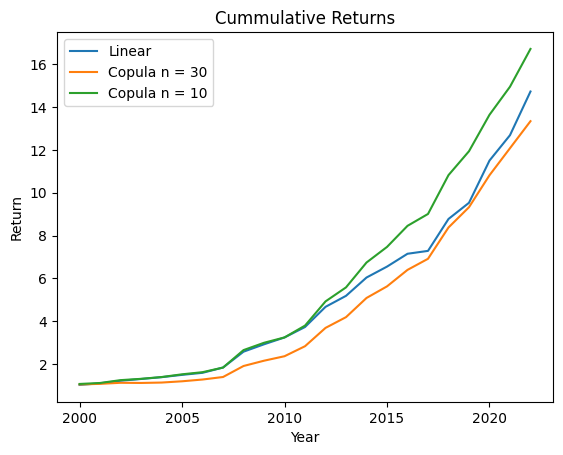

In [15]:
(l_res.iloc[:, 0] +1).cumprod().plot(title='Cummulative Returns', xlabel = 'Year', ylabel = 'Return')
(c30.iloc[:, 0] +1).cumprod().plot()
(c10.iloc[:, 0] +1).cumprod().plot()
plt.legend(['Linear', 'Copula n = 30', "Copula n = 10"])

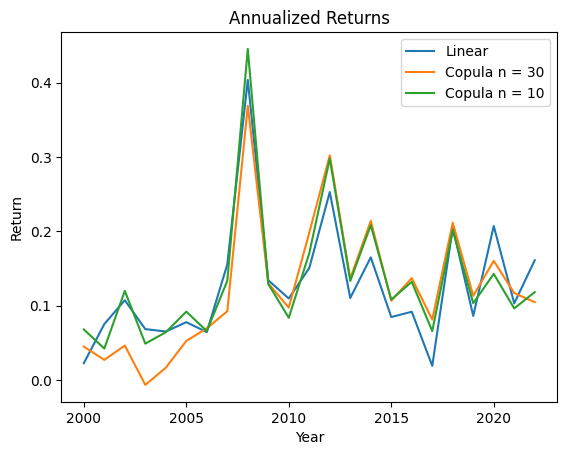

In [16]:
l_res.iloc[:, 0].plot(title='Annualized Returns', xlabel = 'Year', ylabel = 'Return')
c30.iloc[:, 0].plot()
c10.iloc[:, 0].plot()
plt.legend(['Linear', 'Copula n = 30', "Copula n = 10"])